## Gather Sense of Our Data:
<a id="gather"></a>
The first thing we must do is gather a <b> basic sense </b> of our data. Remember, except for the <b>transaction</b> and <b>amount</b> we dont know what the other columns are (due to privacy reasons). The only thing we know, is that those columns that are unknown have been scaled already.   

<h3> Summary: </h3>
<ul>
<li>The transaction amount is relatively <b>small</b>. The mean of all the mounts made is approximately USD 88. </li>
<li>There are no <b>"Null"</b> values, so we don't have to work on ways to replace values. </li>
<li> Most of the transactions were <b>Non-Fraud</b> (99.83%) of the time, while <b>Fraud</b> transactions occurs (0.17%) of the time in the dataframe. </li>
</ul>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import collections


# Other Libraries
from sklearn.model_selection import (StratifiedShuffleSplit, KFold, StratifiedKFold, train_test_split, 
                                        cross_val_score, GridSearchCV, ShuffleSplit, learning_curve, cross_val_predict)
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, roc_auc_score
from collections import Counter
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
from sklearn import utils
warnings.filterwarnings("ignore")


/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



In [2]:
seed = 42
np.random.seed(seed)
pd.np.random.seed(seed)
utils.check_random_state(seed)

In [3]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/credit-card-fraud-detection"
else:
    PATH="../input"
    
df = pd.read_csv(PATH+"/creditcard.csv")
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# Good No Null Values!
df.isnull().sum().max()

0

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


**Note:**  Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Text(0.5, 1.0, 'Class Distributions ')

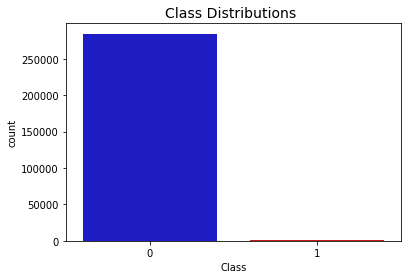

In [7]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions ', fontsize=14)

**Distributions:** By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented in this notebook in the future.

<h2> Scaling and Distributing </h2>
<a id="distributing"></a>
In this phase of our kernel, we will first scale the columns comprise of <b>Time</b> and <b>Amount </b>. Time and amount should be scaled as the other columns. On the other hand, we need to also create a sub sample of the dataframe in order to have an equal amount of Fraud and Non-Fraud cases, helping our algorithms better understand patterns that determines whether a transaction is a fraud or not.

<h3> What is a sub-Sample?</h3>
In this scenario, our subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

<h3> Why do we create a sub-Sample?</h3>
In the beginning of this notebook we saw that the original dataframe was heavily imbalanced! Using the original dataframe  will cause the following issues:
<ul>
<li><b>Overfitting: </b>Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs. </li>
<li><b>Wrong Correlations:</b> Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features. </li>
</ul>

<h3>Summary: </h3> 
<ul>
<li> <b>Scaled amount </b> and <b> scaled time </b> are the columns with scaled values. </li>
<li> There are <b>492 cases </b> of fraud in our dataset so we can randomly get 492(500 about) cases of non-fraud to create our new sub dataframe. </li>
<li>We concat the 492 cases of fraud and non fraud, <b>creating a new sub-sample. </b></li>
</ul>

In [8]:
# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler()

df.insert(0, 'scaled_amount', rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1)))
df.insert(1, 'scaled_time', rob_scaler.fit_transform(df['Time'].values.reshape(-1,1)))

df.drop(['Time','Amount'], axis=1, inplace=True)

# Amount and Time are Scaled!
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Splitting the Data (Original DataFrame)
<a id="splitting"></a>
Before proceeding with the <b> Random UnderSampling technique</b> we have to separate the orginal dataframe. <b> Why? for testing purposes, remember although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques.</b> The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.  

In [9]:
X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=seed, shuffle=False)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# Convert numpy arrays to pandas DataFrame
original_Xtrain = pd.DataFrame(original_Xtrain, columns=X.columns)
original_Xtest = pd.DataFrame(original_Xtest, columns=X.columns)

## Random Under-Sampling:

In this phase of the project we will implement *"Random Under Sampling"* which basically consists of removing data in order to have a more <b> balanced dataset </b> and thus avoiding our models to overfitting.

#### Steps:
<ul>
<li>The first thing we have to do is determine how <b>imbalanced</b> is our class (use "value_counts()" on the class column to determine the amount for each label)  </li>
<li>Once we determine how many instances are considered <b>fraud transactions </b> (Fraud = "1") , we should bring the <b>non-fraud transactions</b> to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492(about 500) cases of non-fraud transactions.  </li>
<li> After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to <b>shuffle the data</b> to see if our models can maintain a certain accuracy everytime we run this script.</li>
</ul>

**Note:** The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of <b>information loss</b> (bringing 492 non-fraud transaction  from 284,315 non-fraud transaction)

In [10]:
# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0].sample(500)

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.shape

(992, 31)

##  Equally Distributing and Correlating: 
<a id="correlating"></a>
Now that we have our dataframe correctly balanced, we can go further with our <b>analysis</b> and <b>data preprocessing</b>.

Distribution of the Classes in the subsample dataset
0    0.504032
1    0.495968
Name: Class, dtype: float64


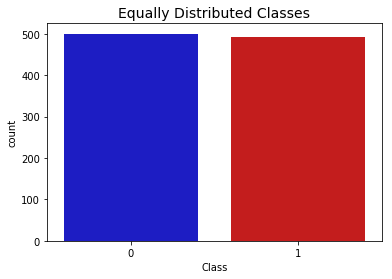

In [11]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))


sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

<h3> Correlation Matrices </h3>
Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample)  in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

### Summary and Explanation: 
<ul>
<li><b>Negative Correlations: </b>V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.  </li>
<li> <b> Positive Correlations: </b> V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction. </li>
<li> <b>BoxPlots: </b>  We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions. </li>
</ul>


**Note: ** We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

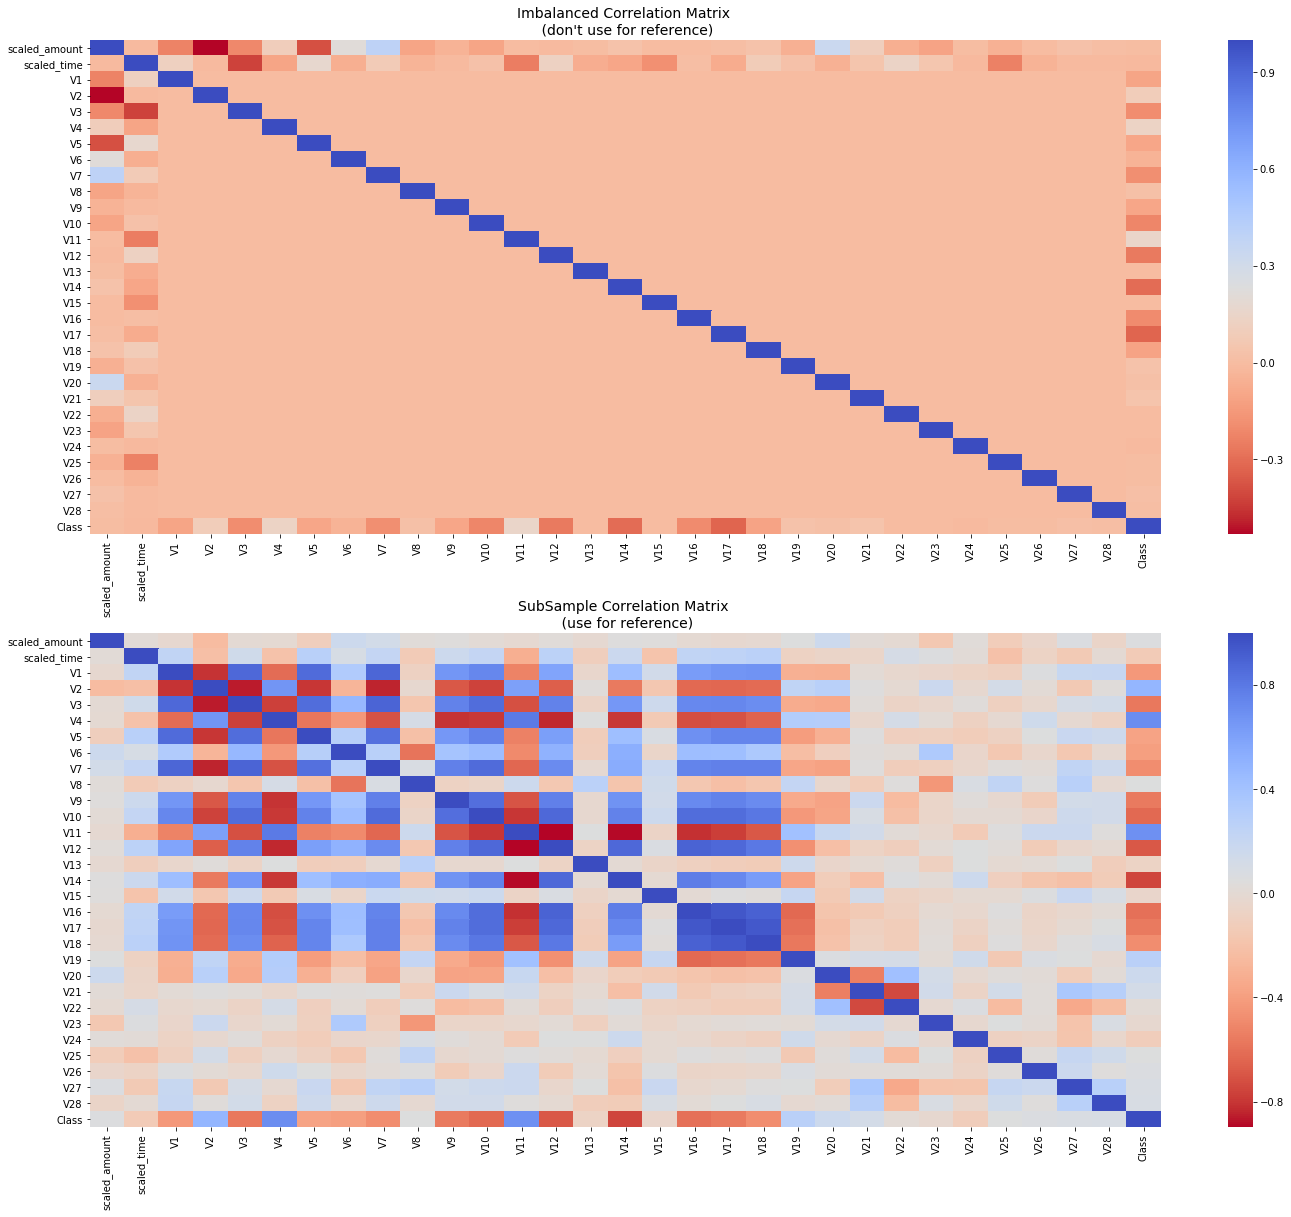

In [12]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [13]:
target = 'Class'
predictors = ['scaled_time', 'scaled_amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

## Features Importance-Most impact one

In [14]:
clf = RandomForestClassifier()

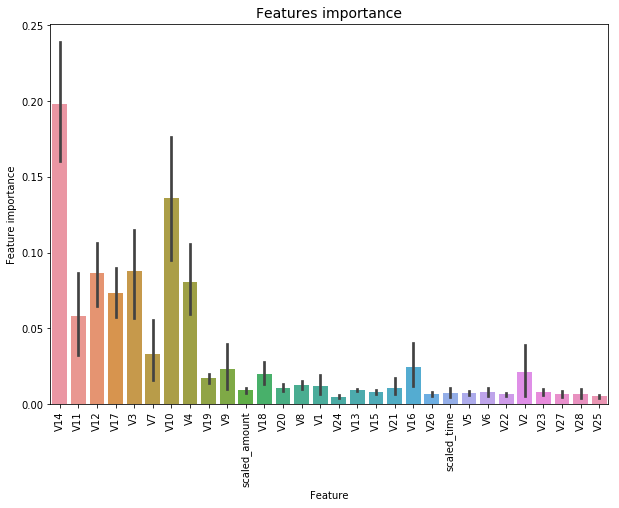

In [15]:
# Initialize an empty DataFrame to accumulate results
final_tmp = pd.DataFrame()

# Execute the code 10 times
for i in range(10):
    clf.fit(new_df[predictors], new_df[target].values)
    # Execute your code here
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance', ascending=False)
    
    # Concatenate the current results to the final DataFrame
    final_tmp = pd.concat([final_tmp, tmp], ignore_index=True)

# Plot the final result
plt.figure(figsize=(10, 7))
plt.title('Features importance', fontsize=14)
s = sns.barplot(x='Feature', y='Feature importance', data=final_tmp)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show()

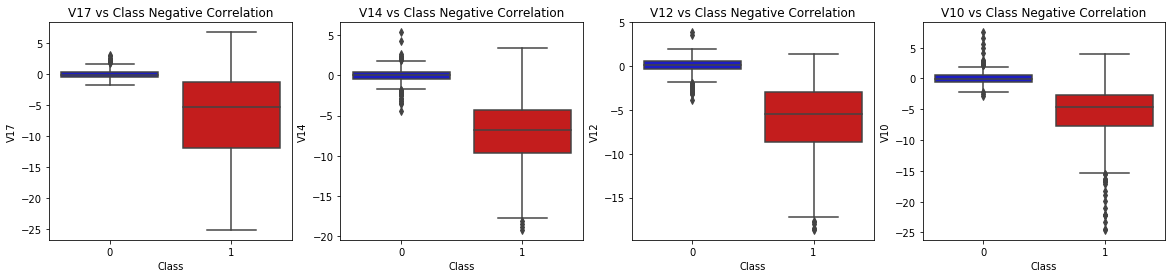

In [16]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

### Looks like they are having relationship between class , you can easily do that with watching class '1' has lower values than class '0'..

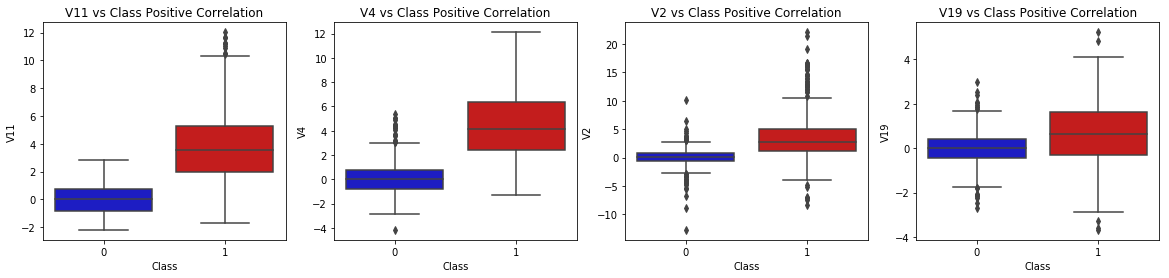

In [17]:

f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

### Looks like they are having relationship between class , you can easily do that with watching class '1' has higher values than class '0'..

## Anomaly Detection IN Feature
<a id="anomaly"></a>


Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models.  <br><br>


### Interquartile Range Method:
<ul>
<li> <b>Interquartile Range (IQR): </b> We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance pass this threshold the instance will be deleted.  </li>
<li> <b>Boxplots: </b> Besides easily seeing the 25th and 75th percentiles (both end of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme). </li>
</ul>

### Outlier Removal Tradeoff:
We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect.  <br><br>

**The Tradeoff:**
The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower accuracy. You can play with this threshold and see how it affects the accuracy of our classification models.


### Summary:
<ul>
<li> <b> Visualize Distributions: </b> We first start by visualizing the distribution of the feature we are going to use to eliminate some of the outliers. V14 is the only feature that has a Gaussian distribution compared to features V12 and V10. </li>
<li><b>Determining the threshold: </b> After we decide which number we will use to multiply with the iqr (the lower more outliers removed), we will proceed in determining the upper and lower thresholds by substrating q25 - threshold (lower extreme threshold) and adding q75 + threshold (upper extreme threshold). </li>
<li> <b>Conditional Dropping: </b> Lastly, we create a conditional dropping stating that if the "threshold" is exceeded in both extremes, the instances will be removed. </li>
<li> <b> Boxplot Representation: </b> Visualize through the boxplot that the number of "extreme outliers" have been reduced to a considerable amount. </li>
</ul>

**Note:** After implementing outlier reduction our accuracy has been improved by over 3%! Some outliers can distort the accuracy of our models but remember, we have to avoid an extreme amount of information loss or else our model runs the risk of underfitting.


**Reference**: More information on Interquartile Range Method: <a src="https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/"> How to Use Statistics to Identify Outliers in Data </a> by Jason Brownless (Machine Learning Mastery blog)

In [18]:
def remove_outliers(df, feature):
    fraud_values = df[feature].loc[df['Class'] == 1].values
    q25, q75 = np.percentile(fraud_values, 25), np.percentile(fraud_values, 75)
    iqr = q75 - q25

    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    outliers = df[(df[feature] > upper) | (df[feature] < lower)]
    print('Feature {} Outliers for Fraud Cases: {}'.format(feature, len(outliers)))
    print('{} outliers are : {}'.format(feature, outliers[feature].values))
    
    df = df.drop(outliers.index)
    print('Number of Instances after outliers removal: {}'.format(len(df)))
    
    # Plotting Box Plot
    plt.figure(figsize=(8, 6))
    plt.boxplot(df[feature], showfliers=True)
    plt.title('Box plot for {}'.format(feature))
    
    # Highlighting outliers
    outlier_indices = list(outliers.index)
    outlier_values = list(outliers[feature])
    plt.scatter(outlier_indices, outlier_values, color='black', label='Outliers')
    plt.legend()
    plt.show()
    
    return df


Feature V14 Outliers for Fraud Cases: 6
V14 outliers are : [  5.36233645 -19.21432549   4.2511544  -18.04999769 -18.49377336
 -18.82208674]
Number of Instances after outliers removal: 986


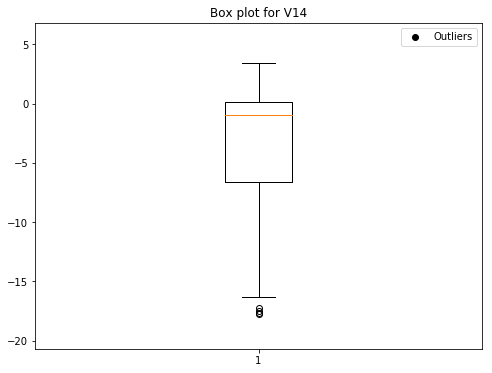

----------------------------------------------------------------------------------------
Feature V12 Outliers for Fraud Cases: 6
V12 outliers are : [-18.68371463 -17.76914346 -18.55369701 -18.04759657 -18.43113103
 -17.63160631]
Number of Instances after outliers removal: 986


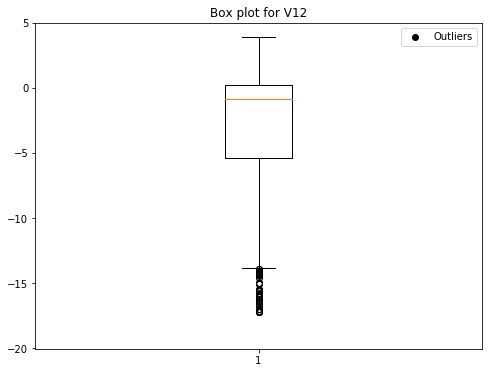

----------------------------------------------------------------------------------------
Feature V10 Outliers for Fraud Cases: 22
V10 outliers are : [-22.18708856 -15.56379134   6.60961809 -16.30353766 -24.40318497
 -15.56379134 -18.91324333 -22.18708856 -16.64962816 -22.18708856
 -16.74604411   5.63217611 -16.60119697 -17.14151364 -18.27116817
 -16.25561175   7.50988774 -22.18708856 -20.94919155 -19.83614885
 -24.58826244 -23.22825484]
Number of Instances after outliers removal: 970


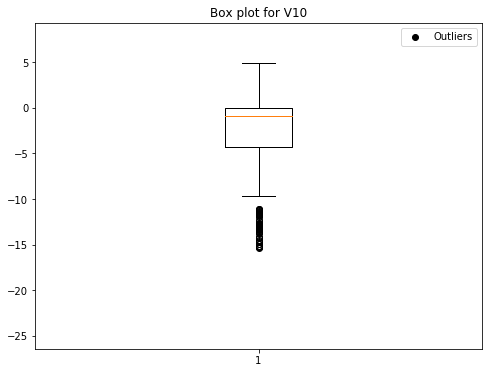

----------------------------------------------------------------------------------------
Feature V11 Outliers for Fraud Cases: 10
V11 outliers are : [11.27792073 12.01891318 10.44684681 11.1524906  11.22847028 10.85301165
 10.54526295 11.66920474 11.61972348 11.02705909]
Number of Instances after outliers removal: 982


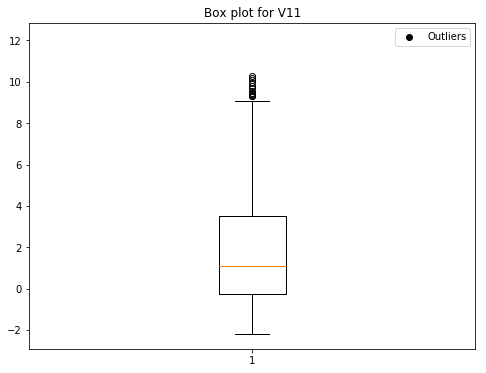

----------------------------------------------------------------------------------------


In [19]:
# Call the function for each feature
features = ['V14', 'V12', 'V10', 'V11']
for feature in features:
    new_df_1 = remove_outliers(new_df, feature)
    print('----' * 22)

In [20]:
new_df_1.shape, new_df.shape

((982, 31), (992, 31))

<h2> Classifiers</h2>
<a id="classifiers"></a>
In this section we will train four types of classifiers and decide which classifier will be more effective in detecting <b>fraud transactions</b>.  Before we have to split our data into training and testing sets and separate the features from the labels.

In [21]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "Random Jungle": RandomForestClassifier(),
    "AdaBoost" : AdaBoostClassifier(),
    "CatBoost" : CatBoostClassifier(verbose = 0),
    "LGBM" : LGBMClassifier()
}

In [22]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

Classifiers:  LogisticRegression Have a training ROC_AUC , Accuracy, Recall & Precision score of 0.99 0.97 0.93 0.05
Classifiers:  LogisticRegression Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.99 0.98 0.89 0.06


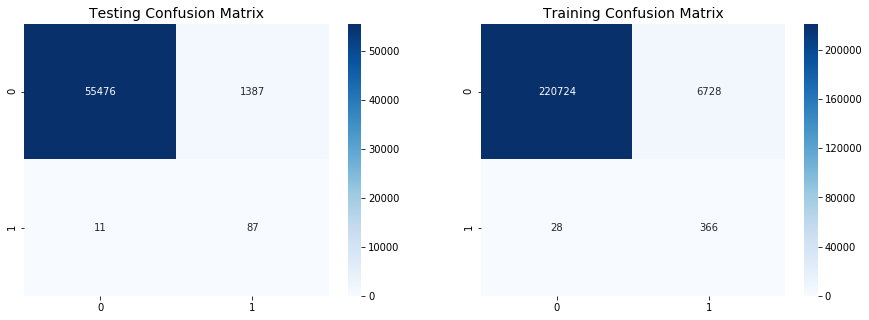

Classifiers:  RandomForestClassifier Have a training ROC_AUC , Accuracy, Recall & Precision score of 1.0 0.96 0.99 0.04
Classifiers:  RandomForestClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 1.0 0.96 1.0 0.04


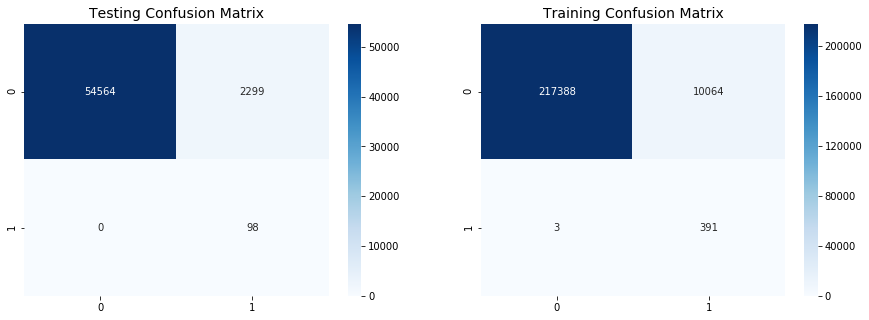

Classifiers:  AdaBoostClassifier Have a training ROC_AUC , Accuracy, Recall & Precision score of 1.0 0.95 0.98 0.04
Classifiers:  AdaBoostClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 1.0 0.96 0.98 0.04


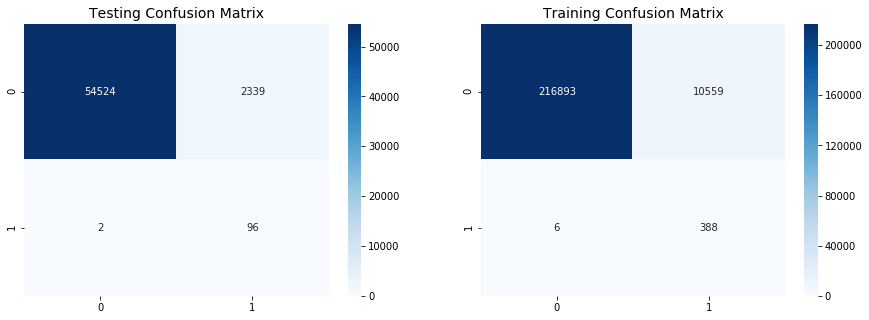

Classifiers:  CatBoostClassifier Have a training ROC_AUC , Accuracy, Recall & Precision score of 1.0 0.98 1.0 0.08
Classifiers:  CatBoostClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 1.0 0.98 1.0 0.09


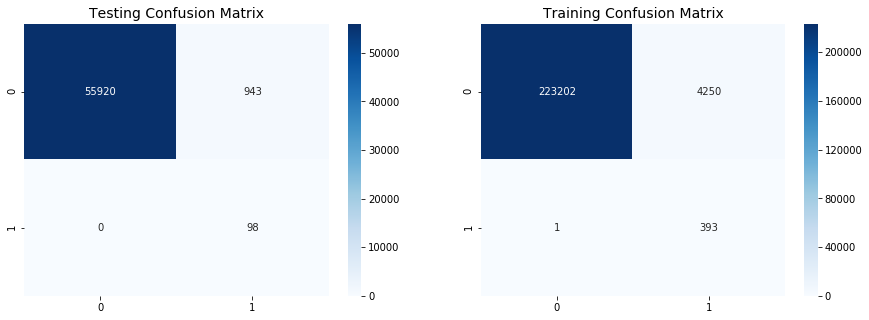

Classifiers:  LGBMClassifier Have a training ROC_AUC , Accuracy, Recall & Precision score of 1.0 0.98 1.0 0.07
Classifiers:  LGBMClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 1.0 0.98 1.0 0.07


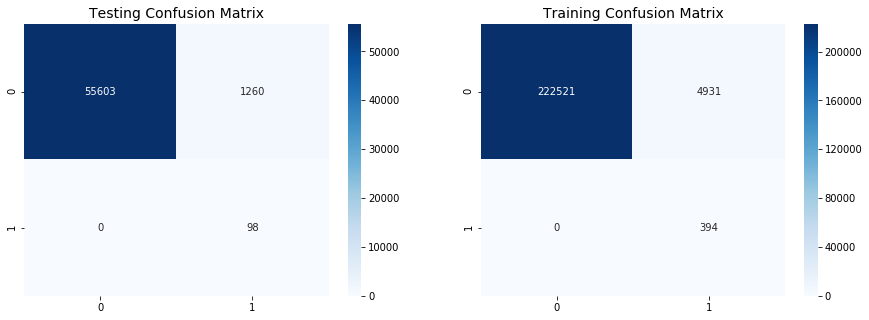

In [23]:
from sklearn.metrics import confusion_matrix

for key, classifier in classifiers.items():
    classifier.fit(X, y)
    original_ypred_train = classifier.predict_proba(original_Xtrain)[:,1]
    original_ypred_test = classifier.predict_proba(original_Xtest)[:,1]
    
    train_roc_auc = roc_auc_score(original_ytrain, original_ypred_train)
    test_roc_auc = roc_auc_score(original_ytest, original_ypred_test)
    
    original_ypred_train = [1 if x >= 0.5 else 0 for x in original_ypred_train]
    original_ypred_test = [1 if x >= 0.5 else 0 for x in original_ypred_test]
    
    # Calculate scores
    train_accuracy = accuracy_score(original_ytrain , original_ypred_train)
    train_recall = recall_score(original_ytrain, original_ypred_train)
    train_precision = precision_score(original_ytrain, original_ypred_train)
    
    test_accuracy = accuracy_score(original_ytest, original_ypred_test)
    test_recall = recall_score(original_ytest, original_ypred_test)
    test_precision = precision_score(original_ytest, original_ypred_test)
    
    print("Classifiers: ", classifier.__class__.__name__, 
          "Have a training ROC_AUC , Accuracy, Recall & Precision score of",
          round(train_roc_auc, 2),
          round(train_accuracy, 2),
          round(train_recall, 2),
          round(train_precision, 2))
    
    print("Classifiers: ", classifier.__class__.__name__, 
          "Have a testing ROC_AUC , Accuracy , Recall & Precision score of", 
          round(test_roc_auc, 2),
          round(test_accuracy, 2),
          round(test_recall, 2),
          round(test_precision, 2))
    
    # Continue with confusion matrix plotting
    cm = confusion_matrix(original_ytest, original_ypred_test)
    cm2 = confusion_matrix(original_ytrain, original_ypred_train)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
    sns.heatmap(cm,
                annot=True, ax=ax1,
                fmt='d', cmap="Blues")
    ax1.set_title('Testing Confusion Matrix', fontsize=14)
    sns.heatmap(cm2,
                annot=True, ax=ax2,
                fmt='d', cmap="Blues")
    ax2.set_title('Training Confusion Matrix', fontsize=14)
    plt.show()

## A Deeper Look into Confusion Matrix:
<a id="logistic"></a>
In this section we will ive a deeper look into the <b> logistic regression classifier</b>.


### Terms:
<ul>
<li><b>True Positives:</b> Correctly Classified Fraud Transactions </li>
<li><b>False Positives:</b> Incorrectly Classified Fraud Transactions</li>
<li> <b>True Negative:</b> Correctly Classified Non-Fraud Transactions</li>
<li> <b>False Negative:</b> Incorrectly Classified Non-Fraud Transactions</li>
<li><b>Precision: </b>  True Positives/(True Positives + False Positives)  </li>
<li><b> Recall: </b> True Positives/(True Positives + False Negatives)   </li>
<li> Precision as the name says, says how precise (how sure) is our model in detecting fraud transactions while recall is the amount of fraud cases our model is able to detect.</li>
<li><b>Precision/Recall Tradeoff: </b> The more precise (selective) our model is, the less cases it will detect. Example: Assuming that our model has a precision of 95%, Let's say there are only 5 fraud cases in which the model is 95% precise or more that these are fraud cases. Then let's say there are 5 more cases that our model considers 90% to be a fraud case, if we lower the precision there are more cases that our model will be able to detect. </li>
</ul>

## Summary:

### Recall starts to descend between 0.98 and 0.99 nevertheless, our precision score is still pretty high and still we **need a descent Precision score**

- As you can see accuracy so high , and ROC_AUC is low, we should trust the **AUC score** here , because **there is high class imbalance**
## You are thinking okay then what if we used *originaltrain* for training and use originialtest for testing..

Classifiers:  LogisticRegression Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.97 1.0 0.53 0.88


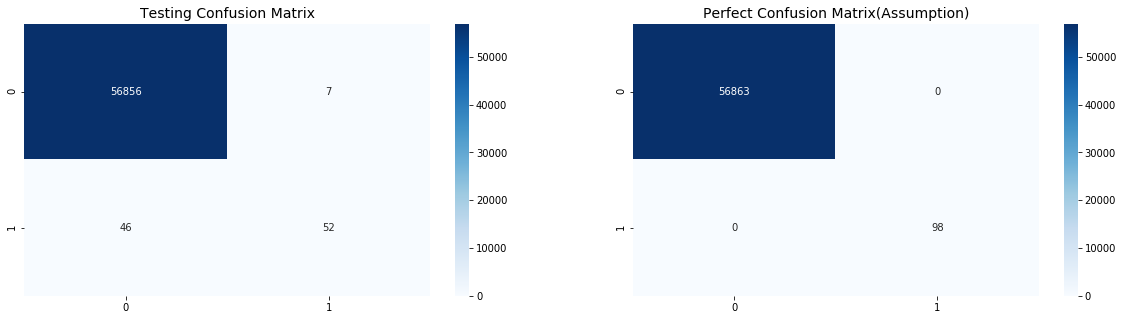

Classifiers:  RandomForestClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.91 1.0 0.71 0.97


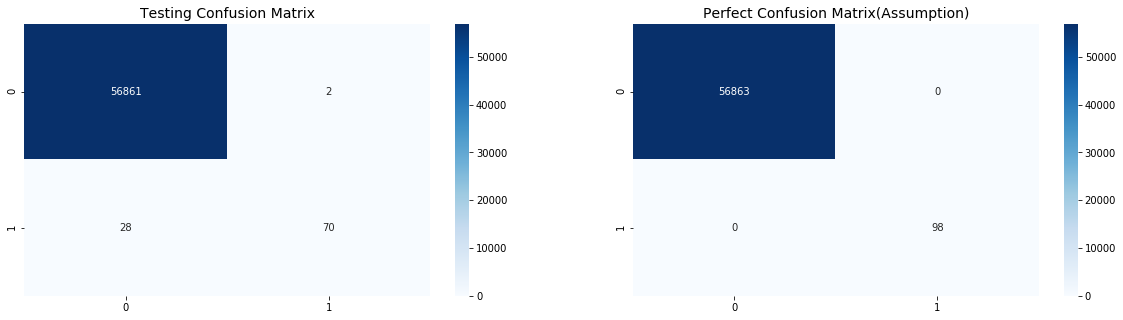

Classifiers:  AdaBoostClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.96 0.5 0.98 0.0


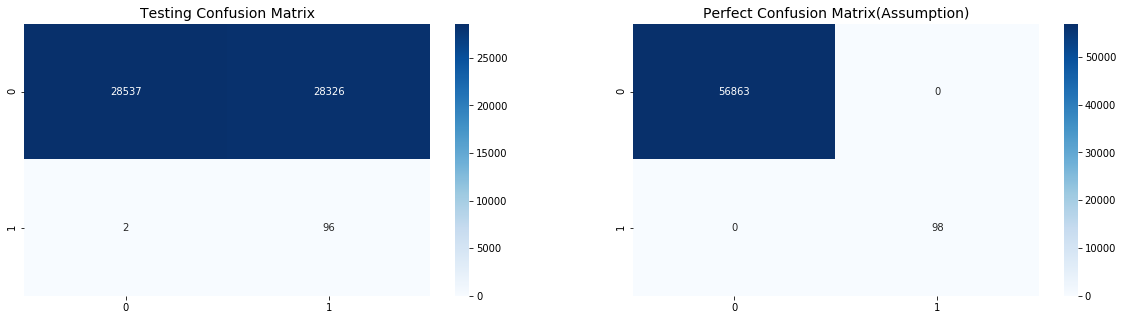

Classifiers:  CatBoostClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.98 1.0 0.71 0.96


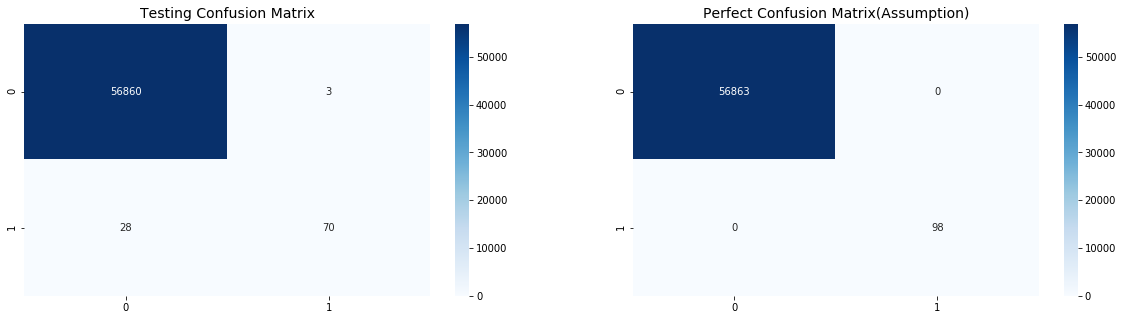

Classifiers:  LGBMClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.61 1.0 0.24 0.25


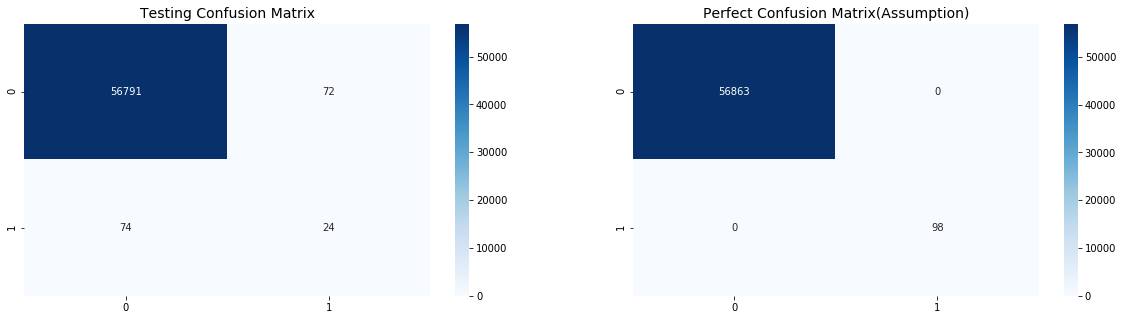

In [24]:
for key, classifier in classifiers.items():
    classifier.fit(original_Xtrain, original_ytrain)
    original_ypred_test = classifier.predict_proba(original_Xtest)[:,1]
    
    test_roc_auc = roc_auc_score(original_ytest, original_ypred_test)
    original_ypred_test = [1 if x >= 0.4 else 0 for x in original_ypred_test]
    
    # Calculate scores
    
    test_accuracy = accuracy_score(original_ytest, original_ypred_test)
    test_recall = recall_score(original_ytest, original_ypred_test)
    test_precision = precision_score(original_ytest, original_ypred_test)
    
    print("Classifiers: ", classifier.__class__.__name__, 
          "Have a testing ROC_AUC , Accuracy , Recall & Precision score of", 
          round(test_roc_auc, 2),
          round(test_accuracy, 2),
          round(test_recall, 2),
          round(test_precision, 2))
    
    cm = confusion_matrix(original_ytest, original_ypred_test)
    cm2 = confusion_matrix(original_ytest, original_ytest)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
    sns.heatmap(cm,
                annot=True, ax=ax1,
                fmt='d', cmap="Blues")
    ax1.set_title('Testing Confusion Matrix', fontsize=14)
    sns.heatmap(cm2,
                annot=True, ax=ax2,
                fmt='d', cmap="Blues")
    ax2.set_title('Perfect Confusion Matrix(Assumption)', fontsize=14)
    plt.show()


In [25]:
from sklearn.ensemble import VotingClassifier

classifiers_1 = {
    "LGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# Convert classifiers to list of tuples (name, classifier)
classifiers_list = list(classifiers_1.items())

# Initialize VotingClassifier with soft voting
voting_classifier = VotingClassifier(estimators=classifiers_list, voting='soft', weights = [0.25, 0.75])

# Fit the VotingClassifier
voting_classifier.fit(original_Xtrain, original_ytrain)

# Predict probabilities using soft voting
original_ypred_test_pred = voting_classifier.predict_proba(original_Xtest)[:,1]

# You can now use the probabilities for further analysis or thresholding

Classifiers: voting Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.98 1.0 0.71 0.96


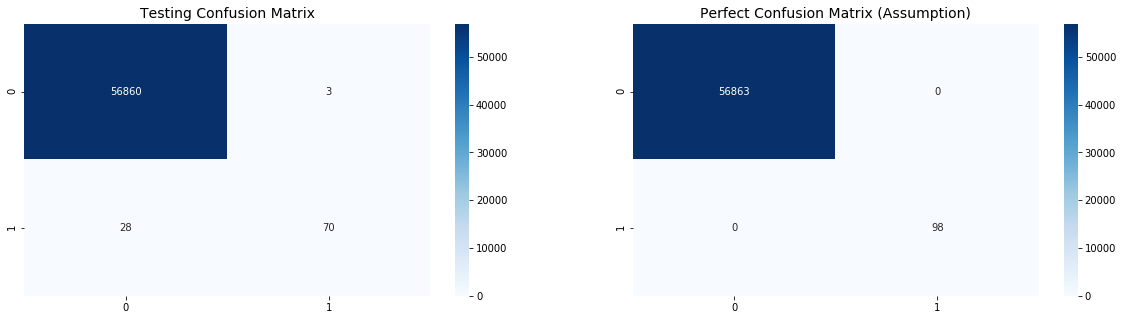

In [26]:
test_roc_auc = roc_auc_score(original_ytest, original_ypred_test_pred)
# You can now use the probabilities for further analysis or thresholding
original_ypred_test = [1 if x >= 0.3 else 0 for x in original_ypred_test_pred]

test_accuracy = accuracy_score(original_ytest, original_ypred_test)
test_recall = recall_score(original_ytest, original_ypred_test)
test_precision = precision_score(original_ytest, original_ypred_test)

print("Classifiers: voting", 
      "Have a testing ROC_AUC , Accuracy , Recall & Precision score of", 
      round(test_roc_auc, 2),
      round(test_accuracy, 2),
      round(test_recall, 2),
      round(test_precision, 2))
    # Confusion matrix
cm = confusion_matrix(original_ytest, original_ypred_test)
cm2 = confusion_matrix(original_ytest, original_ytest)  # Perfect confusion matrix
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
sns.heatmap(cm, annot=True, ax=ax1, fmt='d', cmap="Blues")
ax1.set_title('Testing Confusion Matrix', fontsize=14)
sns.heatmap(cm2, annot=True, ax=ax2, fmt='d', cmap="Blues")
ax2.set_title('Perfect Confusion Matrix (Assumption)', fontsize=14)
plt.show()


## Clearly we are having the problem , we discusssed , model will be confused what to take as **Not Fraud** or **Fraud**, because of such highly imbalanced dataset

# SMOTE Technique (Over-Sampling):
<a id="smote"></a>
<b>SMOTE</b> stands for Synthetic Minority Over-sampling Technique.  Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems". <br><br>


<b> Understanding SMOTE: </b>
<ul>
<li> <b> Solving the Class Imbalance: </b> SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class. </li>
<li><b>Location of the synthetic points: </b>   SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points. </li>
<li> <b>Final Effect:  </b> More information is retained since we didn't have to delete any rows unlike in random undersampling.</li>
<li><b> Accuracy || Time Tradeoff: </b> Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.</li>

</ul>

### Cross Validation Overfitting Mistake:
## Overfitting during Cross Validation:  
In our undersample analysis I want to show you a common mistake I made that I want to share with all of you. It is simple, if you want to undersample or oversample your data you should not do it before cross validating. Why because you will be directly influencing the validation set before implementing cross-validation causing a "data leakage" problem. <b>In the following section you will see amazing precision and recall scores but in reality our data is overfitting!</b>
### The Wrong Way:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/2639934.jpg?401"><br>

As mentioned previously, if we get the minority class ("Fraud) in our case, and create the synthetic points before cross validating we have a certain influence on the "validation set" of the cross validation process. Remember how cross validation works, let's assume we are splitting the data into 5 batches, 4/5 of the dataset will be the training set while 1/5 will be the validation set. The test set should not be touched! For that reason, we have to do the creation of synthetic datapoints "during" cross-validation and not before, just like below: <br>


### The Right Way:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372"> <br>
As you see above, SMOTE occurs "during" cross validation and not "prior" to the cross validation process. Synthetic data are created only for the training set without affecting the validation set.




**References**: 
<ul>
<li><a src="https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation"> 
DEALING WITH IMBALANCED DATA: UNDERSAMPLING, OVERSAMPLING AND PROPER CROSS-VALIDATION </a></li> 

<li> <a src="http://rikunert.com/SMOTE_explained "> SMOTE explained for noobs  </a></li>
<li> <a src="https://www.youtube.com/watch?v=DQC_YE3I5ig&t=794s"> Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn </a></li>
</ul>

In [27]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(random_state=seed)

# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)
# Shuffle the synthetic samples
Xsm_train, ysm_train = utils.shuffle(Xsm_train, ysm_train, random_state=seed)

# Convert numpy arrays to pandas DataFrame
Xsm_train = pd.DataFrame(Xsm_train, columns=X.columns)
ysm_train = pd.DataFrame(ysm_train, columns = ['Class'])

In [28]:
Xsm_train.shape, ysm_train.shape

((454904, 30), (454904, 1))

### Classifier (SMOTE):


Classifiers:  LogisticRegression Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.98 0.99 0.87 0.12


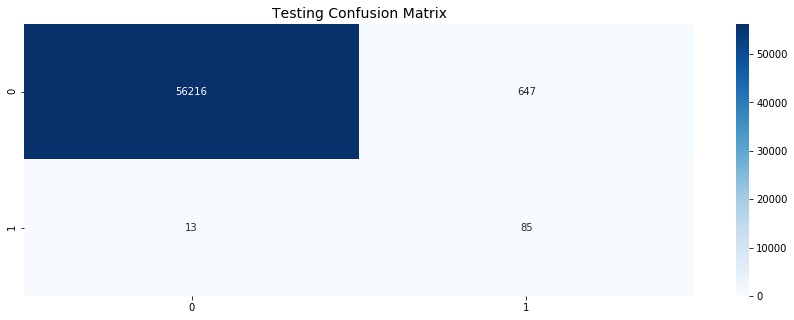

Classifiers:  RandomForestClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.91 1.0 0.68 0.99


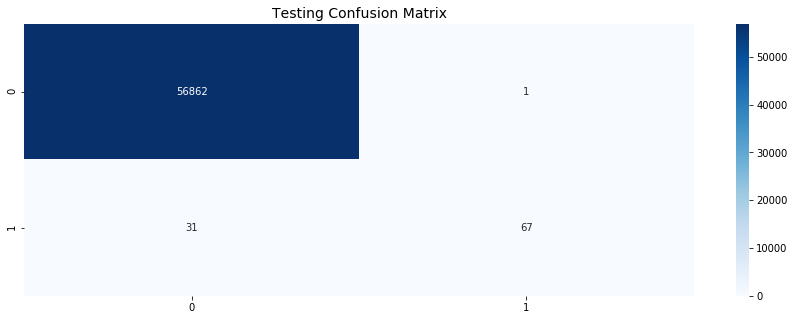

Classifiers:  AdaBoostClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.97 1.0 0.49 0.98


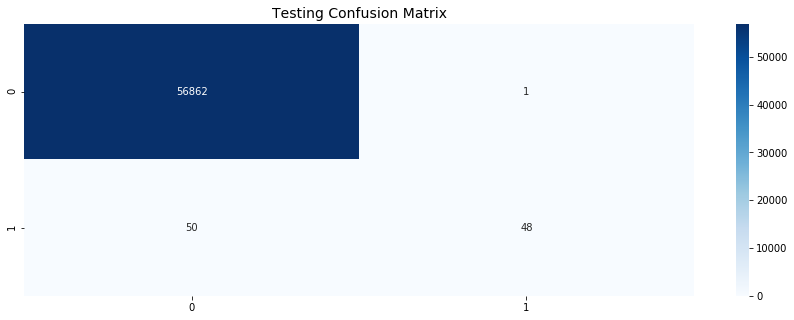

Classifiers:  CatBoostClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.97 1.0 0.74 0.9


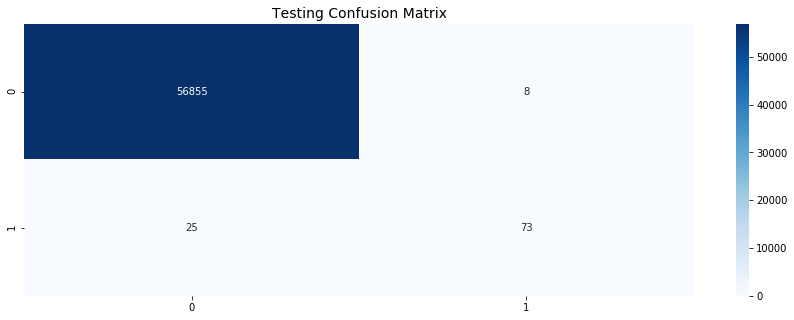

Classifiers:  LGBMClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.97 1.0 0.7 0.88


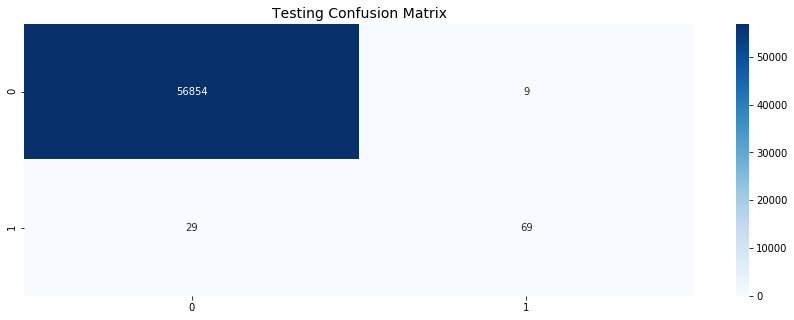

In [29]:
for key, classifier in classifiers.items():
    classifier.fit(Xsm_train, ysm_train)
    original_ypred_test = classifier.predict_proba(original_Xtest)[:,1]
    
    test_roc_auc = roc_auc_score(original_ytest, original_ypred_test)
    original_ypred_test = [1 if x >= 0.5 else 0 for x in original_ypred_test]
    
    # Filter instances where actual is 'Not Fraud' and predicted is 'Fraud'
#     not_fraud_predicted_fraud = (original_ytest == 1) & (original_ypred_test == 0)
#     filtered_original_ytest = original_ytest[not_fraud_predicted_fraud]
#     filtered_original_ypred_test = original_ypred_test[not_fraud_predicted_fraud]
    
    # Calculate confidence of the model for these instances
#     confidence_scores = classifier.predict_proba(original_Xtest)[not_fraud_predicted_fraud][:, 1]
    
    # Calculate scores
    
    test_accuracy = accuracy_score(original_ytest, original_ypred_test)
    test_recall = recall_score(original_ytest, original_ypred_test)
    test_precision = precision_score(original_ytest, original_ypred_test)
    
    print("Classifiers: ", classifier.__class__.__name__, 
          "Have a testing ROC_AUC , Accuracy , Recall & Precision score of", 
          round(test_roc_auc, 2),
          round(test_accuracy, 2),
          round(test_recall, 2),
          round(test_precision, 2))
    
    # Print confidence scores
#     print("Confidence scores for 'Actual: Not Fraud' and 'Predicted: Fraud' instances:", confidence_scores, len(confidence_scores))
    
    cm = confusion_matrix(original_ytest, original_ypred_test)
    fig, (ax1) = plt.subplots(ncols=1, figsize=(15, 5))
    sns.heatmap(cm,
                annot=True, ax=ax1,
                fmt='d', cmap="Blues")
    ax1.set_title('Testing Confusion Matrix', fontsize=14)
    plt.show()

In [30]:
classifiers_1 = {
    "LGBM" : LGBMClassifier(),
    "CatBoost" : CatBoostClassifier(verbose = 0)
}

Classifiers:  LGBMClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.85 1.0 0.7 0.96


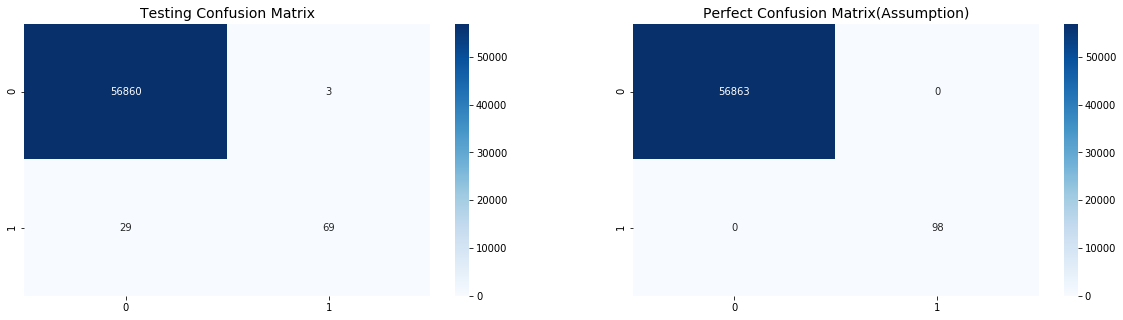

Classifiers:  CatBoostClassifier Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.85 1.0 0.71 0.96


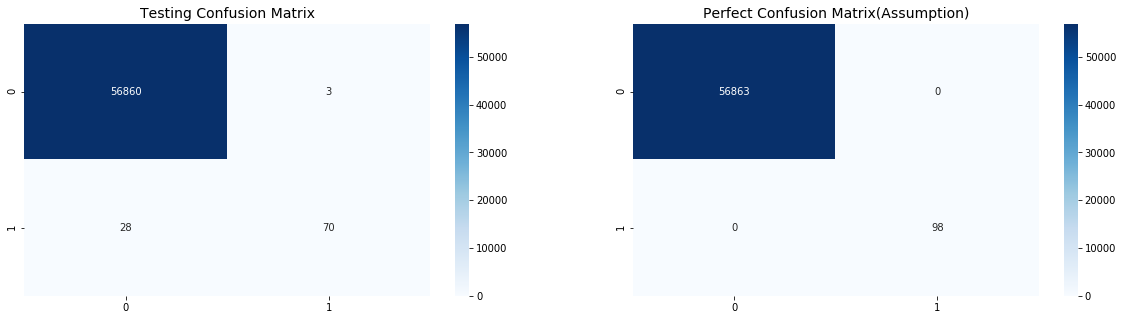

In [31]:
for key, classifier in classifiers_1.items():
    classifier.fit(Xsm_train, ysm_train)
    original_ypred_test_pred = classifier.predict_proba(original_Xtest)[:,1]
    
    test_roc_auc = roc_auc_score(original_ytest, original_ypred_test)
    original_ypred_test = [1 if x >= 0.85 else 0 for x in original_ypred_test_pred]
    
    # Filter instances where actual is 'Not Fraud' and predicted is 'Fraud'
#     not_fraud_predicted_fraud = (original_ytest == 1) & (original_ypred_test == 0)
#     filtered_original_ytest = original_ytest[not_fraud_predicted_fraud]
#     filtered_original_ypred_test = original_ypred_test[not_fraud_predicted_fraud]
    
    # Calculate confidence of the model for these instances
#     confidence_scores = classifier.predict_proba(original_Xtest)[not_fraud_predicted_fraud][:, 1]
    
    # Calculate scores
    
    test_accuracy = accuracy_score(original_ytest, original_ypred_test)
    test_recall = recall_score(original_ytest, original_ypred_test)
    test_precision = precision_score(original_ytest, original_ypred_test)
    
    print("Classifiers: ", classifier.__class__.__name__, 
          "Have a testing ROC_AUC , Accuracy , Recall & Precision score of", 
          round(test_roc_auc, 2),
          round(test_accuracy, 2),
          round(test_recall, 2),
          round(test_precision, 2))
    
    # Print confidence scores
#     print("Confidence scores for 'Actual: Not Fraud' and 'Predicted: Fraud' instances:", confidence_scores, len(confidence_scores))
    
    cm = confusion_matrix(original_ytest, original_ypred_test)
    cm2 = confusion_matrix(original_ytest, original_ytest)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
    sns.heatmap(cm,
                annot=True, ax=ax1,
                fmt='d', cmap="Blues")
    ax1.set_title('Testing Confusion Matrix', fontsize=14)
    sns.heatmap(cm2,
                annot=True, ax=ax2,
                fmt='d', cmap="Blues")
    ax2.set_title('Perfect Confusion Matrix(Assumption)', fontsize=14)
    plt.show()

In [32]:
from sklearn.ensemble import VotingClassifier

classifiers_1 = {
    "LGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# Convert classifiers to list of tuples (name, classifier)
classifiers_list = list(classifiers_1.items())

# Initialize VotingClassifier with soft voting
voting_classifier = VotingClassifier(estimators=classifiers_list, voting='soft', weights = [0.25, 0.75])

# Fit the VotingClassifier
voting_classifier.fit(Xsm_train, ysm_train)

# Predict probabilities using soft voting
original_ypred_test_pred = voting_classifier.predict_proba(original_Xtest)[:,1]

Classifiers: voting Have a testing ROC_AUC , Accuracy , Recall & Precision score of 0.98 1.0 0.72 0.96


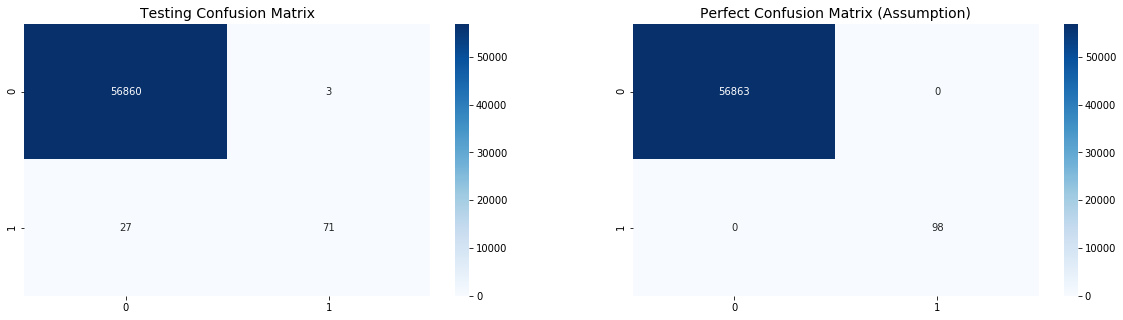

In [33]:
test_roc_auc = roc_auc_score(original_ytest, original_ypred_test_pred)
# You can now use the probabilities for further analysis or thresholding
original_ypred_test = [1 if x >= 0.69 else 0 for x in original_ypred_test_pred]

test_accuracy = accuracy_score(original_ytest, original_ypred_test)
test_recall = recall_score(original_ytest, original_ypred_test)
test_precision = precision_score(original_ytest, original_ypred_test)

print("Classifiers: voting", 
      "Have a testing ROC_AUC , Accuracy , Recall & Precision score of", 
      round(test_roc_auc, 2),
      round(test_accuracy, 2),
      round(test_recall, 2),
      round(test_precision, 2))
    # Confusion matrix
cm = confusion_matrix(original_ytest, original_ypred_test)
cm2 = confusion_matrix(original_ytest, original_ytest)  # Perfect confusion matrix
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
sns.heatmap(cm, annot=True, ax=ax1, fmt='d', cmap="Blues")
ax1.set_title('Testing Confusion Matrix', fontsize=14)
sns.heatmap(cm2, annot=True, ax=ax2, fmt='d', cmap="Blues")
ax2.set_title('Perfect Confusion Matrix (Assumption)', fontsize=14)
plt.show()


- We are back ..

### Conclusion: 
Implementing SMOTE on our imbalanced dataset helped us with the imbalance of our labels (more no fraud than fraud transactions). Nevertheless, I still have to state that sometimes the neural network on the oversampled dataset predicts less correct fraud transactions than our model using the undersample dataset. However, remember that the removal of outliers was implemented only on the random undersample dataset and not on the oversampled one. Also, in our undersample data our model is unable to detect for a large number of cases non fraud transactions correctly and instead, misclassifies those non fraud transactions as fraud cases. Imagine that people that were making regular purchases got their card blocked due to the reason that our model classified that transaction as a fraud transaction, this will be a huge disadvantage for the financial institution. The number of customer complaints and customer disatisfaction will increase.  The next step of this analysis will be to do an outlier removal on our oversample dataset and see if our accuracy in the test set improves. <br><br>
